In [1]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
# ============================================================
# 1) Upload NASA Airfoil Self-Noise .dat file
# ============================================================

print("Upload the NASA Airfoil Self-Noise .dat file")
uploaded = files.upload()

fname = list(uploaded.keys())[0]
print(f"Loaded file: {fname}")

# Column names from UCI dataset description
column_names = [
    "frequency_hz",
    "angle_of_attack_deg",
    "chord_length_m",
    "velocity_m_per_s",
    "suction_side_displacement_thickness_m",
    "sound_pressure_level_db"   # <-- target variable
]

df = pd.read_csv(
    io.BytesIO(uploaded[fname]),
    delim_whitespace=True,
    header=None,
    names=column_names
)

print("Dataset shape:", df.shape)
display(df.head())

Upload the NASA Airfoil Self-Noise .dat file


Saving airfoil_self_noise.dat to airfoil_self_noise.dat
Loaded file: airfoil_self_noise.dat
Dataset shape: (1503, 6)


/tmp/ipython-input-3059961759.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


,frequency_hz,angle_of_attack_deg,chord_length_m,velocity_m_per_s,suction_side_displacement_thickness_m,sound_pressure_level_db
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [3]:
# ============================================================
# 2) Set target variable
# ============================================================

TARGET_COLUMN = "sound_pressure_level_db"
print(f"Using target column: {TARGET_COLUMN}")

X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]


Using target column: sound_pressure_level_db


In [4]:
# ============================================================
# 3) Train/test split
# ============================================================

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train/Test shapes:", X_train.shape, X_test.shape)

Train/Test shapes: (1202, 5) (301, 5)


In [5]:
# ============================================================
# 4) Define Models
# ============================================================

models = {
    "LinearRegression": make_pipeline(StandardScaler(), LinearRegression()),
    "Ridge": make_pipeline(StandardScaler(), Ridge(random_state=RANDOM_STATE)),
    "Lasso": make_pipeline(StandardScaler(), Lasso(max_iter=5000, random_state=RANDOM_STATE)),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=RANDOM_STATE)
}


In [7]:
# ============================================================
# 5) Train and evaluate models
# ============================================================

results = []
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():

    model.fit(X_train, y_train);

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    # Calculate MSE first, then take square root for RMSE
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    cv_r2 = cross_val_score(model, X, y, cv=kf, scoring="r2").mean()

    results.append({
        "model": name,
        "r2_train": r2_train,
        "r2_test": r2_test,
        "cv_r2_mean": cv_r2,
        "rmse_test": rmse_test,
        "mae_test": mae_test
    })

    print(f"[{name}] "
          f"R2_train={r2_train:.4f} | R2_test={r2_test:.4f} | CV_R2={cv_r2:.4f} "
          f"| RMSE={rmse_test:.4f} | MAE={mae_test:.4f}")

[LinearRegression] R2_train=0.5034 | R2_test=0.5583 | CV_R2=0.5051 | RMSE=4.7041 | MAE=3.6724
[Ridge] R2_train=0.5034 | R2_test=0.5581 | CV_R2=0.5051 | RMSE=4.7050 | MAE=3.6738
[Lasso] R2_train=0.3457 | R2_test=0.3461 | CV_R2=0.3456 | RMSE=5.7236 | MAE=4.7047
[RandomForest] R2_train=0.9908 | R2_test=0.9347 | CV_R2=0.9302 | RMSE=1.8092 | MAE=1.2983
[GradientBoosting] R2_train=0.9240 | R2_test=0.8735 | CV_R2=0.8854 | RMSE=2.5177 | MAE=1.8609


In [8]:
# ============================================================
# 6) Present results table
# ============================================================

res_df = pd.DataFrame(results).set_index("model")
display(res_df.sort_values("r2_test", ascending=False))

,r2_train,r2_test,cv_r2_mean,rmse_test,mae_test
model,,,,,
RandomForest,0.990791,0.934668,0.930228,1.809158,1.298274
GradientBoosting,0.924047,0.873468,0.885435,2.517748,1.860865
LinearRegression,0.503448,0.558298,0.505137,4.704109,3.672415
Ridge,0.503446,0.558137,0.505148,4.704966,3.673843
Lasso,0.345724,0.346104,0.345639,5.723571,4.704654


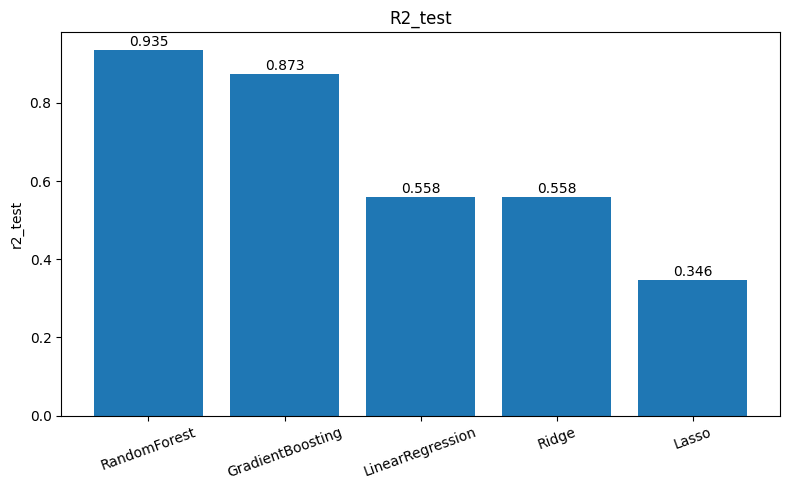

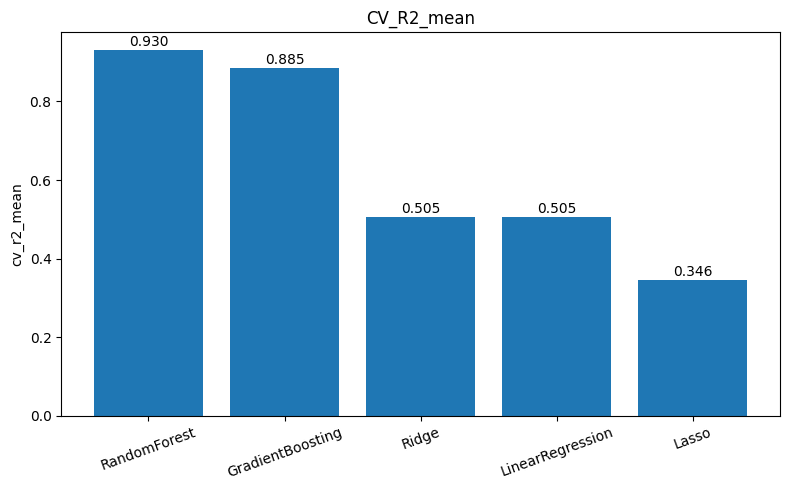

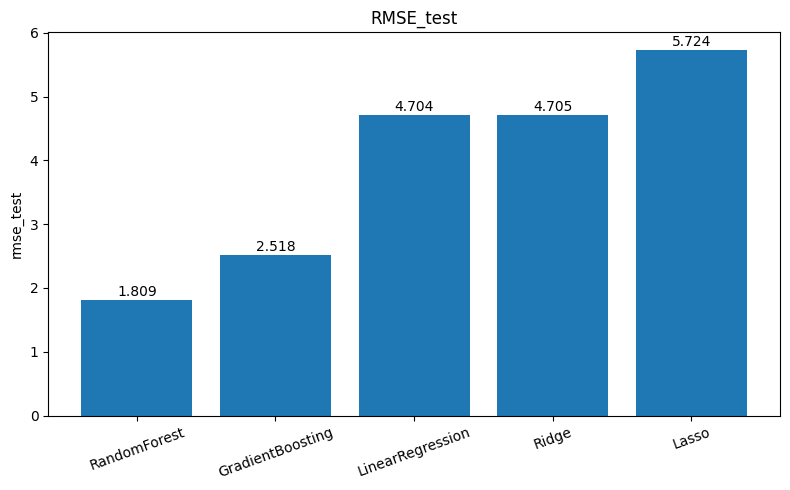

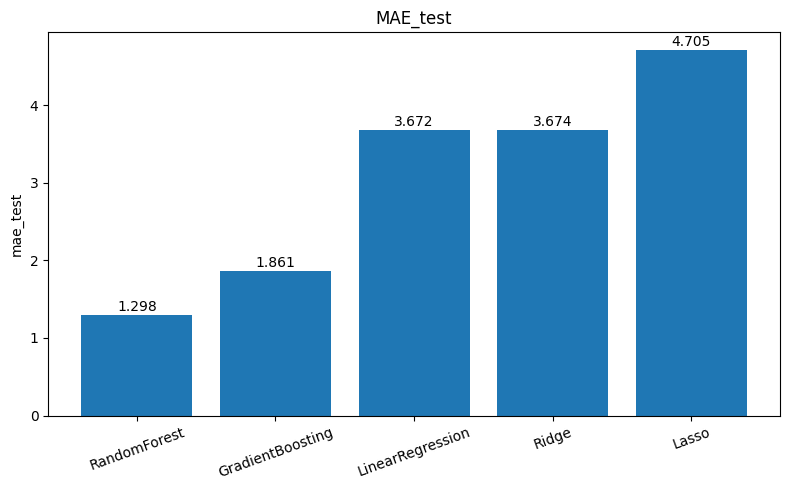

In [9]:
# ============================================================
# 7) Plot comparisons
# ============================================================

metrics_info = {
    "R2_test": ("r2_test", True),
    "CV_R2_mean": ("cv_r2_mean", True),
    "RMSE_test": ("rmse_test", False),
    "MAE_test": ("mae_test", False)
}

for title, (col, higher_better) in metrics_info.items():
    plt.figure(figsize=(8, 5))
    vals = res_df[col]
    order = vals.sort_values(ascending=not higher_better)

    bars = plt.bar(order.index, order.values)
    plt.title(title)
    plt.ylabel(col)
    plt.xticks(rotation=20)

    for bar in bars:
        h = bar.get_height()
        plt.annotate(f"{h:.3f}",
                     xy=(bar.get_x() + bar.get_width() / 2, h),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center')

    plt.tight_layout()
    plt.show()

In [10]:
# ============================================================
# 8) Save results to CSV
# ============================================================

output_file = "airfoil_regression_results.csv"
res_df.to_csv(output_file)
print(f"Saved results to {output_file}")

Saved results to airfoil_regression_results.csv
